<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Specify-NPZ-file-paths" data-toc-modified-id="Specify-NPZ-file-paths-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Specify NPZ file paths</a></span></li><li><span><a href="#Load-NPZ-and-convert-into-PyTorch-DataLoader" data-toc-modified-id="Load-NPZ-and-convert-into-PyTorch-DataLoader-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load NPZ and convert into PyTorch DataLoader</a></span></li><li><span><a href="#Look-at-distribution-of-class-frequencies-to-identify-class-imbalances" data-toc-modified-id="Look-at-distribution-of-class-frequencies-to-identify-class-imbalances-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Look at distribution of class frequencies to identify class imbalances</a></span></li><li><span><a href="#Example-visualization" data-toc-modified-id="Example-visualization-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Example visualization</a></span></li><li><span><a href="#Example-visualization-(animate-validation-data)" data-toc-modified-id="Example-visualization-(animate-validation-data)-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Example visualization (animate validation data)</a></span></li></ul></li><li><span><a href="#Defining-the-Training-Components" data-toc-modified-id="Defining-the-Training-Components-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Defining the Training Components</a></span><ul class="toc-item"><li><span><a href="#Segmentation-Model" data-toc-modified-id="Segmentation-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Segmentation Model</a></span></li><li><span><a href="#Loss-function,-$\mathscr{L}\big(f_{\theta}(x),-y\big)$" data-toc-modified-id="Loss-function,-$\mathscr{L}\big(f_{\theta}(x),-y\big)$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loss function, $\mathscr{L}\big(f_{\theta}(x), y\big)$</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Optimizer</a></span></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Metrics</a></span></li><li><span><a href="#Tensorboard-Logger-(SummaryWriter)" data-toc-modified-id="Tensorboard-Logger-(SummaryWriter)-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Tensorboard Logger (<code>SummaryWriter</code>)</a></span></li></ul></li><li><span><a href="#Train-the-Model" data-toc-modified-id="Train-the-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the Model</a></span><ul class="toc-item"><li><span><a href="#Define-training-loop" data-toc-modified-id="Define-training-loop-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define training loop</a></span></li><li><span><a href="#Analyze-training-curves-in-TensorBoard" data-toc-modified-id="Analyze-training-curves-in-TensorBoard-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Analyze training curves in TensorBoard</a></span></li><li><span><a href="#Run-the-training-loop-for-prescribed-num_epochs" data-toc-modified-id="Run-the-training-loop-for-prescribed-num_epochs-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Run the training loop for prescribed <code>num_epochs</code></a></span></li></ul></li><li><span><a href="#Evaluate-model-on-training-and-validation-sets" data-toc-modified-id="Evaluate-model-on-training-and-validation-sets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate model on training and validation sets</a></span></li></ul></div>

# Training and Evaluating an Eddy Detection Model  <a class="tocSkip">

The second Jupyter notebook in this chapter walks the reader through the process of loading the SSH maps and eddy data generated in the Introduction notebook using py-eddy-tracker, defining the software components required by PyTorch to perform the eddy detection task, and running the training and evaluation loop with associated metrics and visualizations.

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # useful on multi-GPU systems with multiple users

# Fix manual seeds for reproducibility
import torch
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [3]:
num_epochs = 250  # can lower this to save time
batch_size = 256  # can lower this if you get an out of memory error

# Load Data

We use NPZ files generated using the `np.savez_compressed()` method.

## Specify NPZ file paths

In [4]:
data_root = os.path.join(os.path.expanduser("~"), "ML_eddies")
train_folder = os.path.join(data_root, "cds_ssh_1998-2018_10day_interval")
val_folder = os.path.join(data_root, "cds_ssh_2019_10day_interval")
train_file = os.path.join(train_folder, "subset_pet_masks_with_adt_1998-2018_lat14N-46N_lon166W-134W.npz")
val_file = os.path.join(val_folder, "subset_pet_masks_with_adt_2019_lat14N-46N_lon166W-134W.npz")

## Load NPZ and convert into PyTorch DataLoader

A utility function, `get_eddy_dataloader()`, will be used to generate Pytorch `DataLoader` objects. 
</br>


### The `val_split` keyword (default = 0) <a class="tocSkip">
This function has a `val_split` keyword argument that defaults to 0. If `val_split > 0`, the function will perform a train-test split with the specified fraction of data to withhold for validation. `get_eddy_dataloader()` returns **two** outputs, the second of which is None (and can thus be ignored) if val_split = 0. 

<div class="alert alert-block alert-info">
    <b>💡 Tip:</b></br>
    It is important to use a validation set to make sure that the model does not overfit the training data. The most obvious sign of overfitting is when training loss continues to improve while validation loss stays unchanged or increases.
</div>
   
The `get_eddy_dataloader()` function also pins the dataset to CPU memory, which enables asynchronous transfer from RAM (the "host") to GPU VRAM ("device"), similar to TensorFlow's __[prefetching mechanism](https://www.tensorflow.org/guide/data_performance)__. See __[this discussion](https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723)__ for further details on PyTorch's implementation of this.

The function also has a `binary` keyword argument, which is False by default. If set to True, then the resulting segmentation mask will only consist of two classes: eddy or not eddy. In other words, the masks don't distinguish between cyclonic and anticyclonic eddies if `binary = True`.

In [5]:
from data_utils import get_eddy_dataloader

# set binary = false if we want to distinguish between cyclonic and anticyclonic
binary = False
num_classes = 2 if binary else 3
train_loader, _ = get_eddy_dataloader(train_file, binary=binary, batch_size=batch_size)
val_loader, _ = get_eddy_dataloader(
    val_file, binary=binary, batch_size=batch_size, shuffle=False
)

Read 987 samples from /home/edwin/ML_eddies/cds_ssh_1998-2018_10day_interval/subset_pet_masks_with_adt_1998-2018_lat14N-46N_lon166W-134W.npz.
Read 47 samples from /home/edwin/ML_eddies/cds_ssh_2019_10day_interval/subset_pet_masks_with_adt_2019_lat14N-46N_lon166W-134W.npz.


## Look at distribution of class frequencies to identify class imbalances

Next, we take a look at the distribution of classes in our training dataset from the Northern Pacific from 1998-2018. 

In [6]:
import numpy as np
train_masks = train_loader.dataset.masks.copy()
class_frequency = np.bincount(train_masks.flatten())
total_pixels = sum(class_frequency)
print(
    f"Total number of pixels in training set: {total_pixels/1e6:.2f} megapixels"
    f" across {len(train_masks)} SSH maps\n"
    f"Number of pixels that are not eddies: {class_frequency[0]/1e6:.2f} megapixels "
    f"({class_frequency[0]/total_pixels * 100:.2f}%)\n"
    f"Number of pixels that are anticyclonic eddies: {class_frequency[1]/1e6:.2f} megapixels "
    f"({class_frequency[1]/total_pixels * 100:.2f}%)\n"
    f"Number of pixels that are cyclonic eddies: {class_frequency[2]/1e6:.2f} megapixels "
    f"({class_frequency[2]/total_pixels * 100:.2f}%)\n"
)

Total number of pixels in training set: 16.17 megapixels across 987 SSH maps
Number of pixels that are not eddies: 11.71 megapixels (72.43%)
Number of pixels that are anticyclonic eddies: 2.33 megapixels (14.39%)
Number of pixels that are cyclonic eddies: 2.13 megapixels (13.18%)



The statistics show that $\sim$72.4% of the ocean is classified as "not eddies". Thus, a simple function such as
```
def model(x):
    return 0
```

would actually achieve an accuracy of 72.4% on the training data and a *recall* on the "not eddies" class of 1! We will discuss metrics to address this data imbalance in the following sections.

## Example visualization

In PyTorch, `DataLoaders` have a `dataset` attribute, which maps to the original PyTorch `Dataset` that the `DataLoader` is loading. </br>
By calling `train_loader.dataset`, we get something like:
```
Out[]: <data_utils.EddyDataset at 0x7f23ef307940>
```
This means that the underlying dataset for our `DataLoader` is an `EddyDataset`, which is defined in data_utils.py. The `EddyDataset` class is a subclass/extension/implementation of the base `Dataset` class in PyTorch and includes a method called `plot_sample()`, which we will use to visualize the dataset we just loaded. 

In this visualization, the left column shows the *Geophysical Variable* (GV) that will be used as the input, $x$, to our eddy detection model while the right column shows the *segmentation mask*, which is the *label*, $y$, used to evaluate the loss function and optimize the model's parameters.

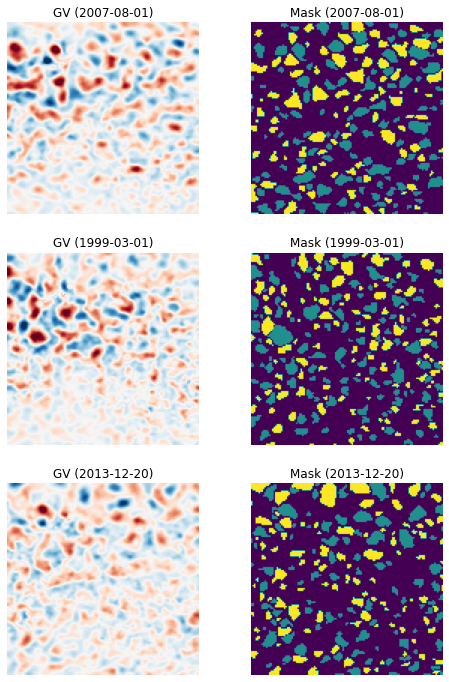

In [7]:
train_loader.dataset.plot_sample(N=3)

In the sample above, notice that there are some large eddies that are missed by the py-eddy-tracker algorithm

## Example visualization (animate validation data)

The `EddyDataset` class also has a method called `animate` that plots **all** the data provided in the source NPZ file in sequential fashion, i.e., a video. Here, we plot only the validation dataset since plotting ~1000 images from the training set might take a while.

<img src="val_eddies.gif" width="750" align="left">

In [8]:
# from IPython.display import HTML
# animation = val_loader.dataset.animate()
# HTML(animation.to_jshtml())
# animation.save(os.path.join(val_folder, "val_eddies.gif"), writer="pillow")

Drawing animation of GV and segmentation mask


Animating eddies::   0%|          | 0/47 [00:00<?, ?it/s]

# Defining the Training Components

Given a model $f$ parameterized by $\theta$ that generates a prediction $\hat{y}$, i.e., $\hat{y} = f_{\theta}(x)$, the goal of training is to optimize the parameters $\theta$ such that a given loss function $\mathscr{L}\big(f_{\theta}(x), y\big)$ is minimized.

We have defined $x$ and $y$ by loading the dataset in [the previous section](#Load-Data). Thus we need to define the following components:

## 2.1 The model, $f_\theta(x)$ <a class="tocSkip">
Here, we will be using EddyNet (Lguensat, 2018), which is a model based off U-Net (Ronneberger , 2015).

## 2.2 The loss function, $\mathscr{L}\big(f_{\theta}(x), y\big)$ <a class="tocSkip">
We will start with the standard __[cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)__ and leave further experimentation with different loss functions as a homework assignment. In particular, Lguensat et al. use a custom overlap-based loss function based on the *dice coefficient*. An example implementation is provided in the `custom_losses.py` source file.

## 2.3 The optimizer <a class="tocSkip">
We need a means by which to update the parameters $\theta$ to minimize $\mathscr{L}$. This is known as the **optimizer**. An example optimizer is Stochastic Gradient Descent, more commonly known as SGD. Here, we use the __[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)__ optimizer (__[Kingma, 2014](https://arxiv.org/abs/1412.6980)__), which uses SGD with an adaptive learning rate. Adam is __["much more forgiving to hyperparameters, including a bad learning rate."](http://karpathy.github.io/2019/04/25/recipe/)__

## 2.4 & 2.5 Logging metrics and Tensorboard `SummaryWriter` <a class="tocSkip">
In addition, we will also define a couple additional elements to monitor our training progress, namely **metrics**, and a **logger** by which we write those metrics into __[Tensorboard]( https://www.tensorflow.org/tensorboard)__.

## Segmentation Model

There are several ways by which one can identify eddies from sea-surface features. For example, one can develop a model that identifies the center of each eddy and, for a given snapshot of sea surface properties, returns a table of centroids. Object detection models can also draw bounding boxes around each detected eddy and return their positions. Here, we will be using EddyNet (Lguensat, 2018), which is a model based off U-Net (Ronneberger, 2015). EddyNet, and the U-net architecture upon which it is based, is a **segmentation** model. Segmentation is the task of assigning a class to each pixel in the provided image. For this problem, EddyNet will classify each pixel according to whether it is 1) not part of an eddy, 2) part of an anticyclonic eddy, or 3) part of a cyclonic eddy.


In [10]:
import torch
from models.eddynet import EddyNet
num_classes = 2 if binary else 3
model_name = "eddynet"  # we'll log this in Tensorboard
model = EddyNet(num_classes, num_filters=16, kernel_size=3)
if torch.cuda.is_available(): 
    model.to(device="cuda")

## Loss function, $\mathscr{L}\big(f_{\theta}(x), y\big)$

We will start with the standard __[cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)__ and leave further experimentation with different loss functions as "homework". In particular, Lguensat et al. use a custom overlap-based loss function based on the *dice coefficient*. An example implementation is provided in the `custom_losses.py` source file.

<div class="alert alert-block alert-success">
📕<b>Try it out: </b></br>
    Try to implement the F<sub>1</sub> score as a <b>loss function</b> and train the segmentation model with it. What are the main differences between the training curves (loss; metrics) from the cross entropy loss and the F<sub>1</sub>-derived/Dice coefficient loss? Does one loss function lead to better performance than the other? Note that Lguensat et al. use a <i>weighted</i> loss function. Try experimenting with weighting the loss function based on class frequencies as well.
</div>

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
# TODO (homework): Try 
# loss_fn = torch.nn.CrossEntropyLoss(weight=torch.Tensor(total_pixels/class_frequency))

## Optimizer

We need a means by which to update the parameters $\theta$ to minimize $\mathscr{L}$. This is known as the **optimizer**. An example optimizer is Stochastic Gradient Descent, more commonly known as SGD. Here, we use the __[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)__ optimizer (__[Kingma, 2014](https://arxiv.org/abs/1412.6980)__), which uses SGD with an adaptive learning rate. Adam is __["much more forgiving to hyperparameters, including a bad learning rate."](http://karpathy.github.io/2019/04/25/recipe/)__


### One-cycle learning rate scheduler <a class="tocSkip">

We will also use a learning rate scheduler that sets the Adam optimizer's learning rate based on the 1cycle policy.</br>
The 1cycle policy anneals the learning rate from an initial learning rate (`initial_lr`) to some maximum learning rate (`max_lr`) and then to some minimum learning rate *much lower than the initial learning rate*. This policy was initially described in the paper: __[Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)__ (Smith and Topin, 2018).

<div class="alert alert-block alert-success">
📕<b>Try it out: </b></br>
    After you start the training loop, keep an eye on the learning rate at each iteration using Tensorboard. What is it's shape? 
    
After the first run, try changing the `initial_lr` and `max_lr` parameters based on suggestions in Smith and Topin, and write down any observed changes in the rate at which your training/validation loss decreases.
</div>

In [12]:
# learning rate for use in OneCycle scheduler
initial_lr = 1e-6
max_lr = 5e-4

optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    div_factor=max_lr / initial_lr,
    pct_start=0.3,
)

## Metrics

Eddy detection is an *imbalanced* or *skewed* classification/segmentation problem. This is because most of the ocean is not classified as eddies, i.e., there are fewer examples of eddies (both cyclonic and anticyclonic) compared to regions that are *not* eddies. If, for example, 80% of the training/test data belong to the "not eddies" class and we only use a simple accuracy metric (number of correctly predicted pixels divided by total number of pixels) to measure performance, a simple model that always predicts a value of 0 will result in a 80% accuracy despite the lack of useful results.


### Precision and recall <a class="tocSkip">
Therefore, we need to keep track of specific metrics that quantify the extent to which our model accurately captures eddies. Two common metrics that are used to assess a classifier's performance for imbalanced problems are **precision** and **recall**.
\begin{equation}
\text{Precision} = \frac{TP}{TP + FP}\\
\text{Recall} = \frac{TP}{TP + FN}\\
\end{equation}

In the equations above, $TP$, $FP$, and $FN$ represent *true positive*, *false positive*, and *false negative*, respectively.</br>
$TP$ represents the number of examples that the model correctly predicted as belonging to a certain class.</br>
$FP$ represents the number of examples that the model (incorrectly) predicted as belonging to a certain class, but *actually* belong to a different (i.e., negative) class.</br>
$FN$ represents the number of examples that the model (incorrectly) predicted as *not* belonging to a given class, but actually *are* instances of that class.

Note that we can handle multi-class classification problems in a **one-vs-rest** (also known as **one-vs-all**) or a **one-vs-one** fashion. Classification and segmentation models based on neural networks generally operate in the one-vs-rest paradigm, where each output neuron gives the likelihood of a given sample falling under the class that corresponds to that neuron compared to all the other classes. One-vs-rest means that we treat each class as a separate binary classification problem. In this scenario, the eddy identification problem with 3 classes --- not eddy; anticyclonic eddy; cyclonic eddy --- is split into three binary classification problems:

| Binary Task | Positive Class | Negative "Class" |
|---|---|---|
| 1 | Not eddy | {Anticyclonic, Cyclonic} |
| 2 | Anticyclonic | {Not eddy, Cyclonic} |
| 3 | Cyclonic | {Not eddy, Anticyclonic} |


### F-score (also known as F<sub>1</sub>-Score) <a class="tocSkip">

\begin{align}
    F_1 &= \frac{2\times \text{precision}\times\text{recall}}{\text{precision} + \text{recall}}\\
        &= \frac{2TP}{2TP + FN + FP}
\end{align}
    
The F-score is an alternative metric that one can use to avoid having to trade off between precision and recall. The F-score is the __[harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean)__ of precision and recall, thereby aggregating them to a single metric. In multi-class classification, this results in an F-score for each class because we can calculate precision and recall values for each class. An *arithmetic* mean can then be taken across these F-scores to arrive at the *macro*-F metric. If we perform *micro* averaging by summing up TP, FP, and FN across all classes and plugging into the F-score definition, we find that the *micro*-F1 metric is mathematically equivalent to the typical accuracy metric.
    
<div class="alert alert-block alert-success">
📕<b>Try it out: </b></br>
    The `torchmetrics.F1Score` metric provides different options for the `average` argument. What other metric is the `average='micro'`, i.e., F1-micro metric equivalent to? Try to reason about this from the definition of the F1 score provided above.
</div>

In [13]:
import torchmetrics
def get_metrics(N, sync=False):
    """Get the metrics to be used in the training loop.
    Args:
        N (int): The number of classes.
        sync (bool): Whether to use wait for metrics to sync across devices before computing value.
    Returns:
        train_metrics (MetricCollection): The metrics to be used in the training loop.
        val_metrics (MetricCollection): The metrics to be used in validation.
    """
    # Define metrics and move to GPU if available
    metrics = [
        torchmetrics.Accuracy(dist_sync_on_step=sync, num_classes=N),
        torchmetrics.Precision(
            average=None,
            dist_sync_on_step=sync,
            num_classes=N,
        ),
        torchmetrics.Recall(
            average=None,
            dist_sync_on_step=sync,
            num_classes=N,
        ),
#         torchmetrics.F1Score(  # TODO: Homework: verify in tensorboard that this is equivalent to accuracy
#             average="micro",
#             dist_sync_on_step=sync,
#             num_classes=N,
#         ),
        torchmetrics.F1Score(
            average="none",  # return F1 for each class
            dist_sync_on_step=sync,
            num_classes=N,
        )
    ]
    if torch.cuda.is_available():  # move metrics to the same device as model
        [metric.to("cuda") for metric in metrics]

    train_metrics = torchmetrics.MetricCollection(metrics)
    val_metrics = train_metrics.clone()
    return train_metrics, val_metrics

train_metrics, val_metrics = get_metrics(num_classes)

## Tensorboard Logger (`SummaryWriter`)


We use Tensorboard to log our loss and metrics throughout the training process. __[Weights and Biases](https://wandb.ai/site)__ is also a good experiment logging/monitoring tool.

Our log directory will be two folders up (i.e., in the repository's root folder) and in a folder called "tensorboard". We also include the current timestamp to identify the specific experiment. For example a tensorboard log_dir would look like, `/path/to/eddy-detection/tensorboard/2022-01-20_17-30`. 

<div class="alert alert-block alert-success">
💡 For more information on Tensorboard, please visit: <a href="https://www.tensorflow.org/tensorboard">https://www.tensorflow.org/tensorboard</a>
<br>For the Torch-specific docs, see: <a href="https://pytorch.org/docs/stable/tensorboard.html">https://pytorch.org/docs/stable/tensorboard.html</a>
</div>


Example Tensorboard logs:

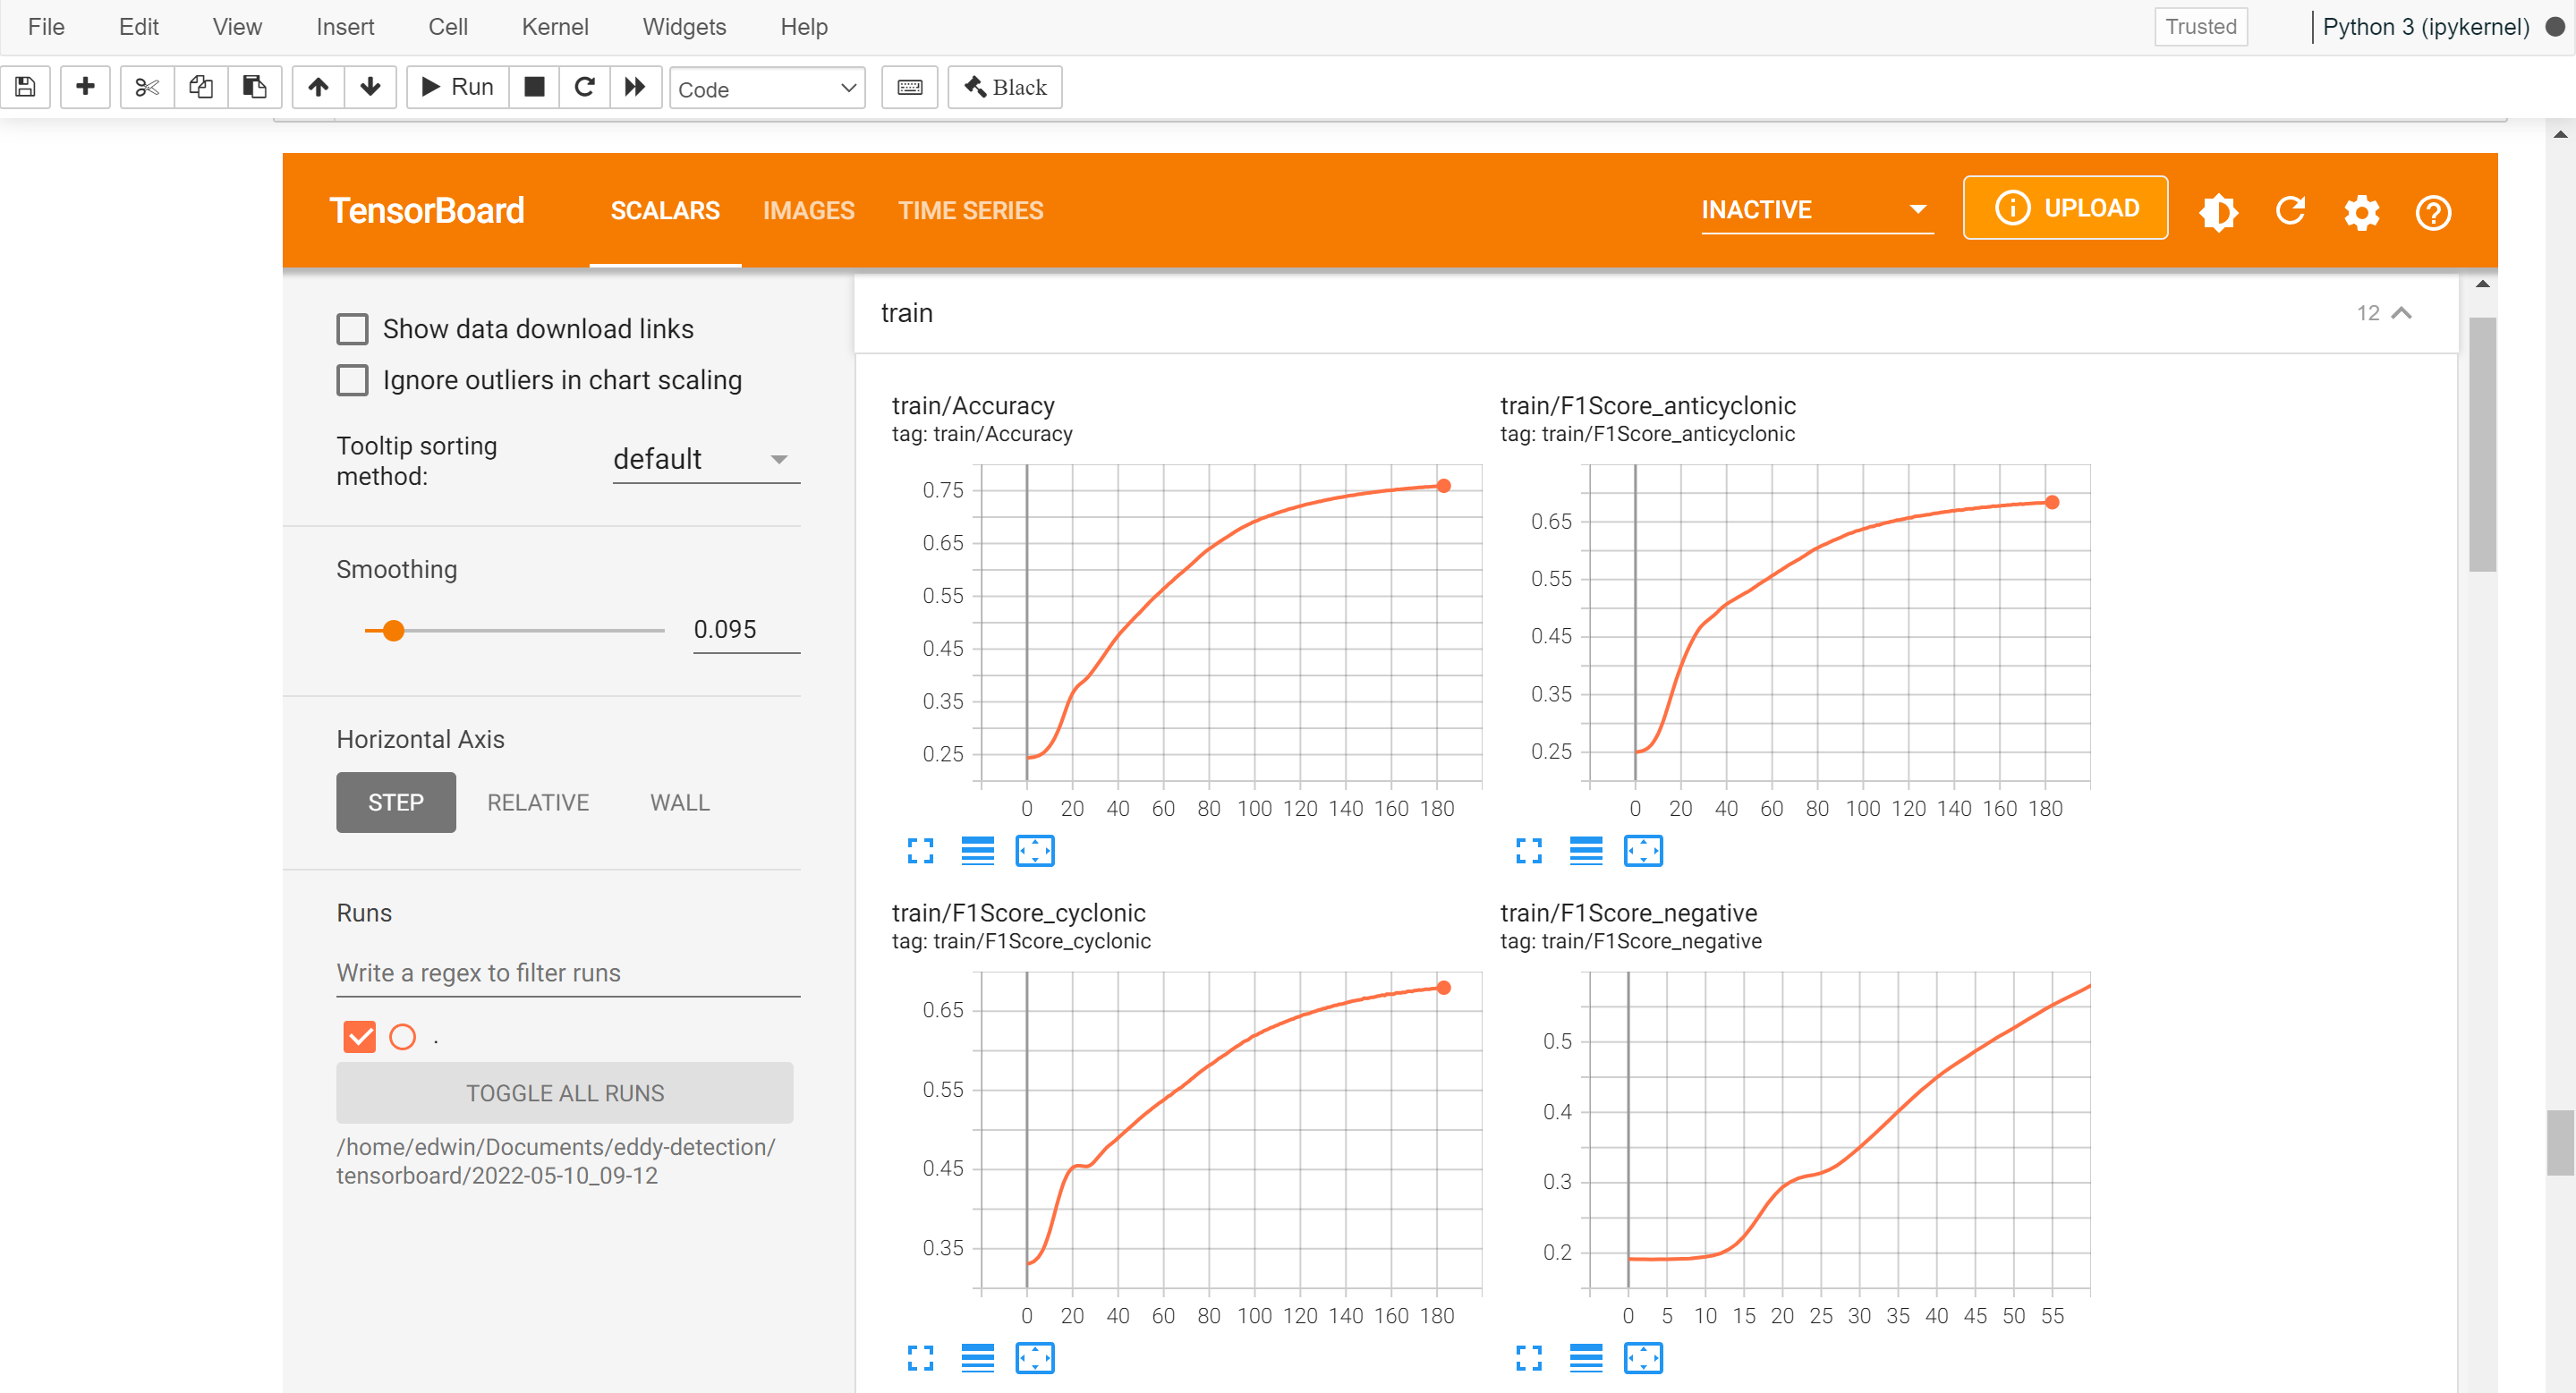

In [14]:
import datetime
from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = os.path.join(
    os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))),
    "tensorboard",
    # add current timestamp
    f"{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')}",
)
writer = SummaryWriter(log_dir=tensorboard_dir)
print(
    f"{''.join(['=']*(28 + len(writer.log_dir)))}\n"
    f"Writing Tensorboard logs to {writer.log_dir}"
    f"\n{''.join(['=']*(28 + len(writer.log_dir)))}"
)

Writing Tensorboard logs to /home/edwin/Documents/eddy-detection/tensorboard/2022-05-10_09-12


# Train the Model
## Define training loop

Once we have all the elements of our machine learning problem defined, we can write a function that uses all these components to iteratively update our model's parameters $\theta$. For this problem, we organize the code into several logical units or *functions* at the **epoch** and **batch** level. 

<div class="alert alert-block alert-warning">
💡 <b>Note:</b></br>
Epoch refers to a complete iteration across all samples in the (training) set. Machine learning datasets tend to be large and are difficult to fit in memory during the model training (i.e., parameter optimization) process. Datasets are typically split into <i>minibatches</i> before being fed into the optimizer/training loop. Thus each epoch consists of multiple minibatches (typically shortened to "batches").
</div>

For each epoch, the `run_epoch` function iterates through the dataset using PyTorch's `DataLoader` object, which generates minibatches of a prescribed size. For each batch, we then call the `run_batch()` function, which 1) calls the model's forward pass on the batch of sea surface property snapshots to generate pixel-level predictions, 2) compares these predictions to the provided ground truth labels to calculate the metrics, 3) run the model's backward pass to update its parameters and 4) log the current metrics/progress to Tensorboard.

After every epoch of the training data, `run_epoch()` also runs an the model in evaluation mode (i.e., forward pass only - for predictions) on the validation set. From the validation set, we choose a few random images whose sea surface property snapshots, ground truth, and predictions will be logged in Tensorboard as images. 

In [15]:
import cv2  # use cv2 to count eddies by drawing contours around segmentation masks
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from eddy_train_utils import run_batch, write_metrics_to_tensorboard, filter_scalar_metrics, EarlyStopping

num_plots_in_tensorboard = 5
# will populate this later with random numbers:
random_plot_indices = np.zeros((num_plots_in_tensorboard,), np.uint8)


def run_epoch(
    epoch,
    model,
    loss_fn,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    train_metrics,
    val_metrics,
    writer,
):
    leave = epoch == num_epochs - 1  # leave progress bar on screen after last epoch

    model.train()
    # training set
    for batch_num, (gvs, seg_masks, date_indices) in enumerate(train_loader):
        train_loss = run_batch(
            model, loss_fn, gvs, seg_masks, optimizer, scheduler, train_metrics
        )
        iter_num = epoch * len(train_loader) + batch_num
        writer.add_scalar("train/lr", scheduler.get_last_lr()[-1], iter_num)

    # validation set
    images, preds, labels, dates = [], [], [], []
    model.eval()
    with torch.no_grad():
        val_loss = num_examples = 0
        for gvs, masks, date_indices in val_loader:
            # continue
            loss_, pred_batch = run_batch(
                model, loss_fn, gvs, masks, metrics=val_metrics, return_pred=True
            )
            val_loss += loss_
            num_examples += np.prod(gvs.shape)
            # keep track of images, preds, labels for plotting
            images.append(gvs)
            preds.append(pred_batch)
            labels.append(masks)
            dates.append(date_indices)

    # calculate average validation loss across all samples
    # num_examples should be equal to sum of all pixels
    val_loss = val_loss / num_examples

    # plot validation images and log to tensorboard
    ## move images, preds, labels, dates to cpu
    images = torch.cat(images).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    preds = torch.cat(preds).cpu().numpy()
    dates = torch.cat(dates).cpu().numpy()
    ## convert indices to actual dates
    dates = [val_loader.dataset.dates[i].strftime("%Y-%m-%d") for i in dates]

    # take random images from validation set
    if epoch == 0:
        indices_ = np.random.choice(
            len(images), num_plots_in_tensorboard, replace=False
        )
        for i, idx in enumerate(indices_):
            random_plot_indices[i] = idx
    fig, ax = plt.subplots(num_plots_in_tensorboard, 3, figsize=(20, 30))
    for n, i in enumerate(random_plot_indices):
        date, img, mask, pred = dates[i], images[i], labels[i], preds[i]
        artists = plot_eddies_on_axes(
            date, img, mask, pred, ax[n, 0], ax[n, 1], ax[n, 2]
        )
    plt.tight_layout()
    writer.add_figure(f"val/sample_prediction", fig, global_step=epoch)

    # Update tensorboard
    train_m = write_metrics_to_tensorboard(
        num_classes, train_metrics, writer, epoch, "train"
    )
    val_m = write_metrics_to_tensorboard(num_classes, val_metrics, writer, epoch, "val")

    writer.add_scalar("train/loss", train_loss, epoch)
    writer.add_scalar("val/loss", val_loss, epoch)

    # reset metrics after each epoch
    train_metrics.reset()
    val_metrics.reset()

    train_m = filter_scalar_metrics(train_m)
    val_m = filter_scalar_metrics(val_m)

    return train_loss, val_loss, train_m, val_m


def plot_eddies_on_axes(date, img, mask, pred, a1, a2, a3):
    im1 = a1.imshow(img.squeeze(), cmap="viridis")

    # blit canvas for a1 a2 a3
    a1.figure.canvas.draw()
    a1.figure.canvas.flush_events()
    a2.figure.canvas.draw()
    a2.figure.canvas.flush_events()
    a3.figure.canvas.draw()
    a3.figure.canvas.flush_events()

    # https://stackoverflow.com/a/49159236
    t1 = a1.text(
        0.5,
        1.05,
        f"ADT {date}",
        size=plt.rcParams["axes.titlesize"],
        ha="center",
        transform=a1.transAxes,
    )
    # set axis off
    a1.axis("off")

    # count number of eddies in mask and pred
    mask_anticyclonic = count_eddies(mask, "anticyclonic")
    mask_cyclonic = count_eddies(mask, "cyclonic")
    pred_anticyclonic = count_eddies(pred, "anticyclonic")
    pred_cyclonic = count_eddies(pred, "cyclonic")

    # calculate accuracy between pred and mask
    acc = np.sum(pred == mask) / mask.size
    im2 = a2.imshow(pred, cmap="viridis")
    t2 = a2.text(
        0.5,
        1.05,
        (
            f"Prediction (Acc = {acc:.3f} |"
            f" Num. anticyclonic = {pred_anticyclonic} |"
            f" Num. cyclonic = {pred_cyclonic})"
        ),
        size=plt.rcParams["axes.titlesize"],
        ha="center",
        transform=a2.transAxes,
    )
    a2.axis("off")
    im3 = a3.imshow(mask, cmap="viridis")
    t3 = a3.text(
        0.5,
        1.05,
        (
            f"Ground Truth"
            f" (Num. anticyclonic: {mask_anticyclonic} |"
            f" Num. cyclonic: {mask_cyclonic})"
        ),
        size=plt.rcParams["axes.titlesize"],
        ha="center",
        transform=a3.transAxes,
    )
    a3.axis("off")

    return im1, t1, im2, t2, im3, t3


def count_eddies(arr, eddy_type="both"):
    mask = np.zeros(arr.shape, dtype=np.uint8)
    if eddy_type == "anticyclonic":
        mask[arr == 1] = 1
    elif eddy_type == "cyclonic":
        mask[arr == 2] = 1
    else:
        mask[arr > 0] = 1
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

## Analyze training curves in TensorBoard

Run this cell to initialize a TensorBoard instance, which we will use to monitor the training progress.

After the cell after this one  (i.e., the one that runs `run_epochs`) is running and the model is training, click on the gear icon in the top right and make sure the "Reload data" option is checked.

In [16]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext tensorboard
%tensorboard --bind_all --logdir $writer.log_dir --port=6008  # the default is 6006 but we set it to 6009 to avoid conflicts with other notebooks

## Run the training loop for prescribed `num_epochs`

Here, we implement a training loop that calls the `run_epoch` function for a specified number of epochs, updating the model's parameters $\theta$ using our optimizer to drive down the specified loss function. Here, we implement _early stopping_, which is a form of regularization to prevent the model from overfitting to the training data and losing its generalization ability. To do this, we track the model's performance on the validation set (i.e., SSH + eddy maps from 2019) as it trains on data from 1998-2018 and stop the training once its performance on the 2019 dataset stops increasing (or even decreases) for a specified number of epochs (specified using the `patience` argument). 

<div class="alert alert-block alert-success">
📝<b>Try it out: </b></br>
    In a typical machine learning workflow, researchers/engineers save checkpoints of the model at regular intervals to evaluate the model's training progress and safeguard against potential crashes during the training run, in which case the experiment can be restarted from the saved checkpoint. In the cell below, add a block of code to save a checkpoint every 10 epochs using the `checkpoint_path` variable.
</div>

In [17]:
from eddy_train_utils import add_hparams

# create some aliases
loss, opt, sched = loss_fn, optimizer, scheduler

checkpoint_path = os.path.join(tensorboard_dir, "model_ckpt_{epoch}.pt")
early_stopping = EarlyStopping(
    patience=10,
    path=checkpoint_path,
    min_epochs=30,
)

progress_bar = tqdm(range(num_epochs), desc="Training: ", unit="epoch(s)")
for N in progress_bar:
    train_loss, val_loss, train_m, val_m = run_epoch(
        N,
        model,
        loss,
        opt,
        sched,
        train_loader,
        val_loader,
        train_metrics,
        val_metrics,
        writer,
    )

    # update progress bar
    train_m_copy = {f"train_{k}".lower(): v.cpu().numpy() for k, v in train_m.items()}
    val_m_copy = {f"val_{k}".lower(): v.cpu().numpy() for k, v in val_m.items()}
    progress_bar.set_postfix(**train_m_copy, **val_m_copy)

    # early stopping when validation loss stops improving
    early_stopping.path = checkpoint_path.format(epoch=N)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(
            f"Early stopping at epoch {N}"
            f" with validation loss {val_loss:.3f}"
            f" and training loss {train_loss:.3f}"
        )
        break

    # TODO (homework): save checkpoint every 10 epochs

# add hyperparameters and corresponding results to tensorboard HParams table
hparam_dict = {
    "backbone": model_name,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "num_classes": num_classes,
    "binary_mask": binary,
    "optimizer": optimizer.__class__.__name__,
    "max_lr": max_lr,
    "loss_function": loss_fn.__class__.__name__,
}
metrics_dict = {
    "train/end_epoch": N,
    "train/loss": train_loss,
    "train/Accuracy": train_m["Accuracy"],
    "val/loss": val_loss,
    "val/Accuracy": val_m["Accuracy"],
}
add_hparams(writer, hparam_dict, metrics_dict, epoch_num=N)
writer.close()

# save model to tensorboard folder
model_path = os.path.join(tensorboard_dir, f"model_ckpt_{N+1}.pt")
torch.save(model.state_dict(), model_path)

Training:   0%|          | 0/250 [00:00<?, ?epoch(s)/s]

Early stopping at epoch 193 with validation loss 0.000 and training loss 0.714


# Evaluate model on training and validation sets

Once the training loop is complete, we evaluate the trained model on our validation set (2019) one more time, and generate an animation like the one shown at the beginning of this notebook. Recall that the `val_loader` object returns SSH maps and eddy masks in _minibatches_, so an inner loop across the minibatch is used to generate the animation.

Note: if viewing this notebook on GitHub, right click on the "broken image" icon below and select "Open image in new tab".

<img src="val_predictions.gif" width="800" align="left">

In [18]:
from matplotlib.animation import ArtistAnimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))
    artists = []
    # loop through all SSH maps and eddy masks in 2019
    # and run the model to generate predicted eddy masks
    for n, (ssh_vars, seg_masks, date_indices) in enumerate(val_loader):
        ssh_vars = ssh_vars.to(device)
        seg_masks = seg_masks.to(device)
        # Run the model to generate predictions
        preds = model(ssh_vars)

        # For each pixel, EddyNet outputs predictions in probabilities, 
        # so choose the channels (0, 1, or 2) with the highest prob. 
        preds = preds.argmax(dim=1)
        
        # Loop through all SSH maps, eddy masks, and predicted masks
        # in this minibatch and generate a video
        preds = preds.cpu().numpy()
        seg_masks = seg_masks.cpu().numpy()
        ssh_vars = ssh_vars.cpu().numpy()
        date_indices = date_indices.cpu().numpy()
        for i in range(len(ssh_vars)):
            date, img, mask, pred = date_indices[i], ssh_vars[i], seg_masks[i], preds[i]
            img1, title1, img2, title2, img3, title3 = plot_eddies_on_axes(
                date, img, mask, pred, ax[0], ax[1], ax[2]
            )
            artists.append([img1, title1, img2, title2, img3, title3])
            fig.canvas.draw()
            fig.canvas.flush_events()
    animation = ArtistAnimation(fig, artists, interval=200, blit=True)
    plt.close()
    
animation.save(os.path.join(tensorboard_dir, "val_predictions.gif"), writer="pillow")
HTML(animation.to_jshtml())

Finally, we demonstrate the beginnings of how one can use classical computer vision techniques to recover eddy contours from the predicted segmentation masks. We use the first prediction in the list (i.e., Jan 1, 2019) and use the OpenCV library to identify contours (regardless of anticyclonic or cyclonic). We then show a visualization of the recovered contours, and use the `contourArea` function to determine the average area (in square pixels) enclosed by each contour. This operation can be performed for each prediction to enable eddy tracking and trajectory determination. 

Number of anticyclonic eddies: 154
Number of cyclonic eddies: 162
Number of both eddies: 281
Average contour area: 14.81 sq. pixels


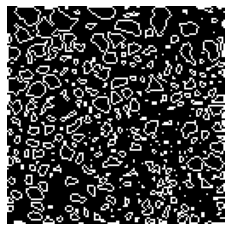

In [20]:
p = preds[0].astype(np.uint8)

print(f"Number of anticyclonic eddies: {count_eddies(p, eddy_type='anticyclonic')}")
print(f"Number of cyclonic eddies: {count_eddies(p, eddy_type='cyclonic')}")
print(f"Number of both eddies: {count_eddies(p, eddy_type='both')}")

# draw contours on the image
thr = cv2.threshold(p, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
contours, hierarchy = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = np.zeros(p.shape, np.uint8)
cv2.drawContours(img, contours, -1, (255, 255, 255), 1)
plt.imshow(img, cmap="gray")
plt.axis("off")

# get average contour area
area = 0
for cnt in contours:
    area += cv2.contourArea(cnt)
area /= len(contours)
print(f"Average contour area: {area:.2f} sq. pixels")